# Assignment — Part A: Transformation

In this part of the assignment, we will explore **planar transformations** using **homography**.

A **homography** is a 3×3 projective transformation that maps points from one plane to another.  
It allows us to **warp** an image so that it aligns geometrically within another image or video.  
This principle is the foundation of **planar transformations** — where one visual element (such as an image or video) is projected onto another in a consistent perspective.

---

## Learning Objectives
By completing this part, you will learn:
1. How to extract and match image features using SIFT and SuperGlue.
2. How to compute a **homography matrix** from point correspondences.
3. How to perform **perspective warping** and **overlay composition**.
4. How to stabilize overlays across frames of a video.

---

## Task Overview

We will perform three major overlay tasks:

- **Task A1:** Overlay an **image onto an image**.  
- **Task A2:** Overlay an **image onto a video**.  
- **Task A3:** Overlay a **video onto a video**.  

Each task builds conceptually upon the previous one.  
We will start with **manual correspondences**, move to **SIFT-based feature matching**, and finally integrate a **deep learning matcher** (**SuperPoint + SuperGlue**) for improved robustness.

In [2]:
# ==============================================================
# Setup
# ==============================================================
# !pip install opencv-python numpy matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

def show_images(imgs, titles=None, cmap=None):
    """Display multiple images side-by-side using matplotlib."""
    if not isinstance(imgs, (list, tuple)):
        imgs = [imgs]
    num = len(imgs)
    titles = titles if titles is not None else [""] * num
    plt.figure(figsize=(5 * num, 5))
    for i, img in enumerate(imgs):
        plt.subplot(1, num, i + 1)
        disp = img
        if disp is None:
            plt.text(0.5, 0.5, "None", ha='center', va='center')
            plt.axis('off')
            continue
        if disp.ndim == 3 and disp.shape[2] == 3:
            disp = cv2.cvtColor(disp, cv2.COLOR_BGR2RGB)
        plt.imshow(disp, cmap=cmap)
        plt.title(titles[i] if i < len(titles) else "")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Step 1: Feature Matching (SIFT Baseline)

### Concept:
To compute a homography, we need **corresponding points** between two images (e.g., corners, edges, or other distinctive features).  
We use **SIFT (Scale-Invariant Feature Transform)** to:
- Detect keypoints that are stable under scale and rotation.
- Compute unique descriptors for each keypoint.
- Match keypoints between two images using **descriptor similarity**.

After matching, we apply **Lowe’s ratio test** to filter out poor matches.

You will now implement the SIFT-based feature matcher class.

In [3]:
# ==============================================================
# Step 1: Feature Matching using SIFT
# ==============================================================

class SIFTMatcher:
    def __init__(self):
        """Initialize SIFT detector and brute-force matcher."""
        self.sift = cv2.SIFT_create()
        # For SIFT descriptors, use L2 norm; enable crossCheck=False for ratio test
        self.bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    def find_matches(self, imgA, imgB, ratio_thresh=0.75):
        """
        Detects SIFT features and finds good matches using Lowe's ratio test.
        Returns: point correspondences (ptsA, ptsB) as float32 arrays.
        """
        if imgA.ndim == 3:
            grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
        else:
            grayA = imgA
        if imgB.ndim == 3:
            grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
        else:
            grayB = imgB

        kpsA, descA = self.sift.detectAndCompute(grayA, None)
        kpsB, descB = self.sift.detectAndCompute(grayB, None)
        if descA is None or descB is None or len(kpsA) == 0 or len(kpsB) == 0:
            return None, None

        knn_matches = self.bf.knnMatch(descA, descB, k=2)
        good = []
        for m, n in knn_matches:
            if m.distance < ratio_thresh * n.distance:
                good.append(m)
        if len(good) < 4:
            return None, None

        ptsA = np.float32([kpsA[m.queryIdx].pt for m in good])
        ptsB = np.float32([kpsB[m.trainIdx].pt for m in good])
        return ptsA, ptsB

## Step 2: Homography Estimation (RANSAC)

### Concept:
A **homography matrix (H)** transforms coordinates from one image plane to another.  
However, due to mismatched points and noise, we use **RANSAC (Random Sample Consensus)** to estimate a robust transformation.

RANSAC repeatedly:
- Selects a random subset of point pairs.
- Computes a candidate homography.
- Evaluates how many pairs agree with it (called **inliers**).
- Selects the model with the highest inlier count.

You will now write a helper function to compute homography using OpenCV.

In [4]:
# ==============================================================
# Step 2: Homography Estimation
# ==============================================================

def compute_homography(ptsA, ptsB):
    """
    Computes the homography matrix H using RANSAC.
    Inputs: matched points (ptsA, ptsB)
    Output: homography matrix H and inlier mask
    """
    if ptsA is None or ptsB is None or len(ptsA) < 4 or len(ptsB) < 4:
        return None, None
    H, mask = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, ransacReprojThreshold=3.0)
    return H, mask

## Step 3: Warping and Compositing

Once the homography matrix **H** is computed, we can transform (warp) the overlay image so that it correctly aligns with the target surface.

In this step, you will:
1. **Warp the overlay image** using `cv2.warpPerspective()` so it fits the target plane.
2. **Generate a feathered mask** to softly blend the overlay edges and make the transition smooth.
3. **Blend** the warped overlay with the destination image using weighted addition.

You will implement two small functions:
- `feather_mask()` — to create a soft-edged mask.
- `warp_and_composite()` — to warp the source and blend it with the destination using the mask.

In [5]:
# ==============================================================
# Step 3: Warping and Compositing
# ==============================================================

def feather_mask(img, k=21):
    """Create a soft mask from non-black regions of the image."""
    if img is None:
        return None
    if img.ndim == 3 and img.shape[2] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    # Threshold non-black regions
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # Blur to feather edges
    k = max(3, int(k) | 1)
    blurred = cv2.GaussianBlur(mask, (k, k), 0)
    # Normalize to [0,1]
    norm = blurred.astype(np.float32) / 255.0
    norm = np.clip(norm, 0.0, 1.0)
    return norm


def warp_and_composite(src, dst, H):
    """Warp the source onto destination using homography and blend."""
    if src is None or dst is None or H is None:
        return dst
    h, w = dst.shape[:2]
    warped = cv2.warpPerspective(src, H, (w, h))
    mask = feather_mask(warped, k=31)
    if mask is None:
        return dst
    if warped.ndim == 2:
        warped = cv2.cvtColor(warped, cv2.COLOR_GRAY2BGR)
    if dst.ndim == 2:
        dst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
    mask3 = np.dstack([mask] * 3)
    composite = (warped * mask3 + dst * (1.0 - mask3)).astype(np.uint8)
    return composite

## Task A1 — Overlay Image on Image

### Objective:
Overlay a static image (rick_and_morty.jpg) onto another image (monitor.jpg).

### Steps:
1. Load the **target image** (rick_and_morty.jpg).  
2. Load the **overlay image** (monitor.jpg).  
3. Manually specify four corner points of the target area you may use paint or whatever suits you.  
4. Define the corners of the overlay image.  
5. Compute the **homography H** and apply the warp.

You will use your `compute_homography()` and `warp_and_composite()` functions here.

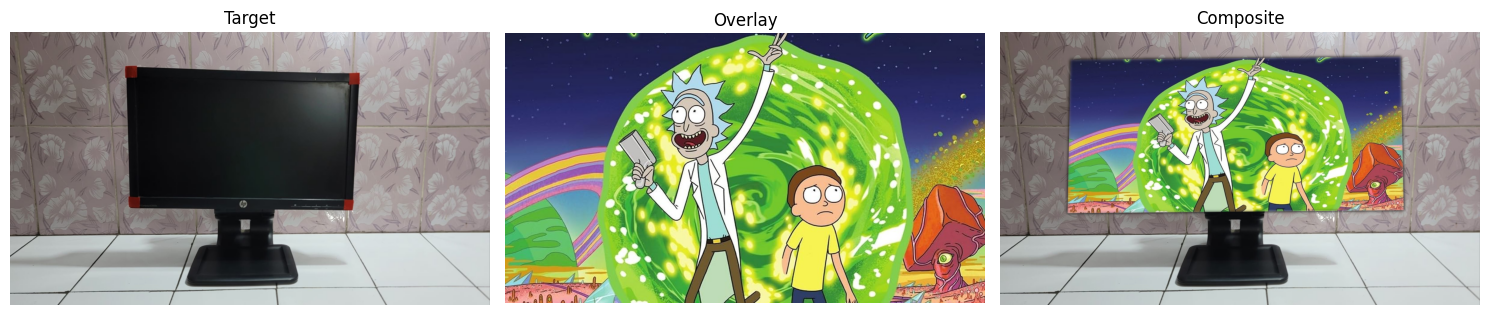

In [6]:
# ==============================================================
# Task A1: Image on Image
# ==============================================================

# Paths from dataset
base = Path("/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset")
img_target_path = base / "monitor.jpg"
img_overlay_path = base / "rick_and_morty.jpg"

img_target = cv2.imread(str(img_target_path))
img_overlay = cv2.imread(str(img_overlay_path))

assert img_target is not None and img_overlay is not None, "Failed to load images"

# Define overlay corners (source)
h_o, w_o = img_overlay.shape[:2]
overlay_corners = np.float32([[0, 0], [w_o - 1, 0], [w_o - 1, h_o - 1], [0, h_o - 1]])

# --- Auto-detect monitor screen quadrilateral (no clicks) ---
def order_corners(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)[:, 0]
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

def detect_screen_corners(bgr):
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8), 1)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h, w = gray.shape
    best = None
    best_area = 0
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4 and cv2.isContourConvex(approx):
            area = cv2.contourArea(approx)
            if area > best_area and area > 0.05 * (h * w):
                best = approx.reshape(-1, 2)
                best_area = area
    if best is None:
        return None
    return order_corners(best)

monitor_pts = detect_screen_corners(img_target)

# Fall back to fixed manual corners if auto-detect fails (no clicks)
if monitor_pts is None:
    monitor_pts = np.float32([
        [235, 95],   # TL (moved inward from bezel)
        [1335, 85],  # TR
        [1345, 595], # BR
        [225, 605]   # BL
    ])

# Compute homography and composite
H, _ = cv2.findHomography(overlay_corners, monitor_pts, cv2.RANSAC, 2.0)
composited = warp_and_composite(img_overlay, img_target, H)

show_images([img_target, img_overlay, composited], ["Target", "Overlay", "Composite"])

## Task A2 — Overlay Image on Video

### Concept:
Extend Task A1 to dynamic frames.  
You will overlay an image (rick_and_morty.jpg) onto a **moving video** by tracking the monitor over time (monitor_video1.jpg).

Each frame:
1. Detect features and match with reference frame.
2. Estimate the new homography H.
3. Warp the overlay image onto the screen region.
4. Use **smoothing** (e.g., average over last N frames) for stability.

You’ll implement a function that automates these steps.

## 3. Select Corresponding Points
Select at least **4 pairs of points** manually from both images.  
These will be used to compute the homography matrix manually.


In [ ]:

# ==============================================================
# Manual Corner Selection Tool
# ==============================================================

def select_corners_manually(image, window_name="Click 4 corners: TL, TR, BR, BL"):
    """
    Interactive tool to manually select 4 corners by clicking
    Returns: np.float32 array of 4 points [TL, TR, BR, BL]
    """
    points = []
    img_display = image.copy()
    
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
            points.append([x, y])
            # Draw the point
            cv2.circle(img_display, (x, y), 5, (0, 255, 0), -1)
            # Label it
            labels = ['TL', 'TR', 'BR', 'BL']
            cv2.putText(img_display, labels[len(points)-1], (x+10, y+10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.imshow(window_name, img_display)
            
            if len(points) == 4:
                # Draw the quadrilateral
                pts = np.array(points, dtype=np.int32)
                cv2.polylines(img_display, [pts], True, (0, 255, 0), 2)
                cv2.imshow(window_name, img_display)
    
    cv2.imshow(window_name, img_display)
    cv2.setMouseCallback(window_name, mouse_callback)
    
    print("\n=== MANUAL CORNER SELECTION ===")
    print("Click 4 corners in this order:")
    print("1. Top-Left (TL)")
    print("2. Top-Right (TR)")
    print("3. Bottom-Right (BR)")
    print("4. Bottom-Left (BL)")
    print("Press any key when done, or 'r' to reset")
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == ord('r'):  # Reset
            points.clear()
            img_display = image.copy()
            cv2.imshow(window_name, img_display)
        elif key != 255 and len(points) == 4:  # Any key pressed and 4 points selected
            break
    
    cv2.destroyAllWindows()
    
    if len(points) == 4:
        print(f"\nSelected corners:\n{np.array(points)}")
        return np.float32(points)
    else:
        print("Error: Need exactly 4 points!")
        return None



def overlay_image_on_video(video_path, overlay_img, out_path, N=5, use_manual_selection=True):
    """
    Overlays image on video with optional manual corner selection
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")
    
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    writer = cv2.VideoWriter(str(out_path), fourcc, fps, (width, height))

    # Read first frame as reference
    ret, ref_frame = cap.read()
    if not ret:
        cap.release()
        writer.release()
        raise RuntimeError("Failed to read first frame")

    # Define overlay corners
    h_o, w_o = overlay_img.shape[:2]
    overlay_corners = np.float32([[0, 0], [w_o - 1, 0], [w_o - 1, h_o - 1], [0, h_o - 1]])

    # GET SCREEN CORNERS
    if use_manual_selection:
        print("\n*** MANUAL CORNER SELECTION MODE ***")
        ref_pts = select_corners_manually(ref_frame)
        if ref_pts is None:
            raise RuntimeError("Manual selection failed!")
    else:
        # Try auto-detection
        ref_pts = detect_screen_corners(ref_frame)
        
        if ref_pts is None:
            print("Warning: Auto-detection failed, using manual coordinates")
            # Fallback coordinates based on actual monitor position in video
            # These are measured from the monitor_video1.mp4 first frame
            ref_pts = np.float32([
                [220, 100],   # Top-left
                [645, 100],   # Top-right
                [645, 330],   # Bottom-right
                [220, 330]    # Bottom-left
            ])
        else:
            ref_pts = shrink_quadrilateral(ref_pts, pixels=20)
            print(f"Auto-detected screen corners: \n{ref_pts}")

    # Save debug image with corners marked
    debug_frame = ref_frame.copy()
    labels = ['TL', 'TR', 'BR', 'BL']
    for i, pt in enumerate(ref_pts):
        cv2.circle(debug_frame, tuple(pt.astype(int)), 8, (0, 255, 0), -1)
        cv2.putText(debug_frame, labels[i], tuple(pt.astype(int) + 10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    pts = ref_pts.astype(np.int32)
    cv2.polylines(debug_frame, [pts], True, (0, 255, 0), 3)
    cv2.imwrite("debug_detection.jpg", debug_frame)
    print("Saved debug_detection.jpg")

    # Compute initial homography
    H0, _ = cv2.findHomography(overlay_corners, ref_pts, cv2.RANSAC, 3.0)
    
    # Setup feature detection for tracking
    detector = cv2.SIFT_create()
    
    # Create mask for reference frame screen region
    mask_ref = np.zeros(ref_frame.shape[:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask_ref, ref_pts.astype(np.int32), 255)
    ref_gray = cv2.cvtColor(ref_frame, cv2.COLOR_BGR2GRAY)
    
    # Detect features in reference frame
    kp_ref, desc_ref = detector.detectAndCompute(ref_gray, mask_ref)
    print(f"Detected {len(kp_ref)} keypoints in reference frame")
    
    H_buffer = []
    frame_idx = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_idx == 0:
            H_frame = H0
        else:
            # Detect features in current frame
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            kp_frame, desc_frame = detector.detectAndCompute(frame_gray, None)
            
            if desc_ref is not None and desc_frame is not None and len(kp_frame) > 4:
                # Match features using BFMatcher
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
                matches = bf.knnMatch(desc_ref, desc_frame, k=2)
                
                # Apply Lowe's ratio test
                good = []
                for match_pair in matches:
                    if len(match_pair) == 2:
                        m, n = match_pair
                        if m.distance < 0.7 * n.distance:
                            good.append(m)
                
                if len(good) >= 4:
                    # Extract matched points
                    pts_ref = np.float32([kp_ref[m.queryIdx].pt for m in good])
                    pts_frame = np.float32([kp_frame[m.trainIdx].pt for m in good])
                    
                    # Compute homography from ref to current frame
                    H_rf_to_f, inlier_mask = cv2.findHomography(pts_ref, pts_frame, cv2.RANSAC, 5.0)
                    
                    if H_rf_to_f is not None:
                        # Compose: overlay -> ref -> current frame
                        H_frame = H_rf_to_f @ H0
                    else:
                        # Use previous homography if estimation fails
                        H_frame = H_buffer[-1] if H_buffer else H0
                else:
                    H_frame = H_buffer[-1] if H_buffer else H0
            else:
                H_frame = H_buffer[-1] if H_buffer else H0
        
        # Temporal smoothing using exponential moving average (EMA)
        # EMA is better than simple averaging for homographies
        alpha = 0.3  # Smoothing factor (0.2-0.4 works well)
        if len(H_buffer) == 0:
            H_avg = H_frame
        else:
            # Weighted average: 70% previous, 30% current (smooth but responsive)
            H_avg = alpha * H_frame + (1 - alpha) * H_buffer[-1]
            H_avg /= (H_avg[2, 2] if abs(H_avg[2, 2]) > 1e-8 else 1.0)
        
        H_buffer.append(H_avg)
        
        # Warp and composite
        composite = warp_and_composite(overlay_img, frame, H_avg)
        writer.write(composite)
        
        frame_idx += 1
        if frame_idx % 30 == 0:
            print(f"Processed {frame_idx} frames...")
    
    cap.release()
    writer.release()
    print(f"\n✓ Video saved to: {out_path}")
    print(f"✓ Total frames processed: {frame_idx}")


def order_corners(pts):
    """Order points as: top-left, top-right, bottom-right, bottom-left"""
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)[:, 0]
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)


def shrink_quadrilateral(corners, pixels=15):
    """Shrink quadrilateral inward by specified pixels"""
    center = corners.mean(axis=0)
    shrunk = []
    for pt in corners:
        direction = center - pt
        direction = direction / np.linalg.norm(direction)
        shrunk.append(pt + direction * pixels)
    return np.float32(shrunk)


def detect_screen_corners(bgr):
    """Auto-detect monitor screen corners - finds dark rectangular region"""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    
    best = None
    best_score = 0
    
    # Strategy 1: Threshold to find dark regions (monitor screen is dark)
    _, thresh = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5,5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        if peri < 200:  # Too small
            continue
            
        approx = cv2.approxPolyDP(cnt, 0.015 * peri, True)
        
        if len(approx) == 4:
            area = cv2.contourArea(approx)
            
            # Monitor should be significant but not huge
            if area > 0.05 * (h * w) and area < 0.7 * (h * w):
                rect = cv2.minAreaRect(approx)
                box_w, box_h = rect[1]
                if box_w > 0 and box_h > 0:
                    aspect = max(box_w, box_h) / min(box_w, box_h)
                    # Monitors are usually wider than tall (aspect ratio 1.3 - 2.5)
                    if 1.2 < aspect < 3.0:
                        M = cv2.moments(approx)
                        if M["m00"] != 0:
                            cx = int(M["m10"] / M["m00"])
                            cy = int(M["m01"] / M["m00"])
                            
                            # Monitor should be in upper-center region
                            if (0.1 * w < cx < 0.9 * w and 0.05 * h < cy < 0.75 * h):
                                # Score based on area and centrality
                                center_score = 1.0 - abs(cx - w/2) / (w/2)
                                score = area * center_score
                                if score > best_score:
                                    best = approx.reshape(-1, 2)
                                    best_score = score
    
    # Strategy 2: Try Canny edges if threshold method failed
    if best is None:
        edges = cv2.Canny(gray, 40, 120)
        edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=2)
        
        contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            if peri < 200:
                continue
            approx = cv2.approxPolyDP(cnt, 0.01 * peri, True)
            
            if len(approx) == 4:
                area = cv2.contourArea(approx)
                if area > 0.05 * (h * w) and area < 0.7 * (h * w):
                    rect = cv2.minAreaRect(approx)
                    box_w, box_h = rect[1]
                    if box_w > 0 and box_h > 0:
                        aspect = max(box_w, box_h) / min(box_w, box_h)
                        if 1.2 < aspect < 3.0:
                            if area > best_score:
                                best = approx.reshape(-1, 2)
                                best_score = area
    
    if best is None:
        return None
    
    return order_corners(best)




In [13]:
# ==============================================================
# RUN THE CODE
# ==============================================================

# Load overlay image
overlay_img = cv2.imread("/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/rick_and_morty.jpg")
if overlay_img is None:
    raise RuntimeError("Failed to load overlay image")

# Run with MANUAL selection (set to True to click on monitor corners)
# INSTRUCTIONS:
# 1. Run this cell
# 2. A window will appear showing the first video frame
# 3. Click on the 4 corners of the MONITOR SCREEN in this order:
#    - Top-Left corner
#    - Top-Right corner
#    - Bottom-Right corner
#    - Bottom-Left corner
# 4. Press any key after clicking all 4 corners
# 5. The video will process automatically

overlay_image_on_video(
    video_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/monitor_video1.mp4",  
    overlay_img=overlay_img,                  
    out_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_A2.mp4",    
    N=5,
    use_manual_selection=True  # <-- Set to True for manual corner selection
)


*** MANUAL CORNER SELECTION MODE ***


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/no0ne/Downloads/abarar-main/venv/lib/python3.12/site-packages/cv2/qt/plugins"



=== MANUAL CORNER SELECTION ===
Click 4 corners in this order:
1. Top-Left (TL)
2. Top-Right (TR)
3. Bottom-Right (BR)
4. Bottom-Left (BL)
Press any key when done, or 'r' to reset

Selected corners:
[[198  34]
 [560  42]
 [552 257]
 [204 254]]
Saved debug_detection.jpg
Detected 44 keypoints in reference frame
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...

✓ Video saved to: /home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_A2.mp4
✓ Total frames processed: 287


## Task A3 — Overlay Video on Video

### Concept:
Now, instead of a static overlay image, you’ll overlay another **video** (R&M_clip.mp4) onto the monitor region in the main video (monitor_video1.mp4).

Both videos move simultaneously — meaning each frame of the source video must be **warped** using the current homography.

The same feature matching and stabilization logic from Task A2 will apply here.

In [33]:
def overlay_video_on_video(target_path, src_path, out_path, N=5, use_manual_selection=True, matcher=None):
    """
    Overlays one video (src) onto another (target) using dynamically updated homography.
    Supports manual or automatic corner selection, temporal smoothing, and feature tracking.
    
    Args:
        target_path: Path to target video (background)
        src_path: Path to source video (overlay)
        out_path: Path to output video
        N: Number of frames for temporal smoothing
        use_manual_selection: If True, manually select corners; if False, auto-detect
        matcher: Optional matcher object (SuperGlueMatcher or None for SIFT)
    """
    cap_t = cv2.VideoCapture(str(target_path))
    cap_s = cv2.VideoCapture(str(src_path))
    if not cap_t.isOpened() or not cap_s.isOpened():
        raise RuntimeError("Cannot open input videos")

    width = int(cap_t.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_t.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap_t.get(cv2.CAP_PROP_FPS) or 25.0
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(out_path), fourcc, fps, (width, height))

    # Reference frames
    ret_t, ref_t = cap_t.read()
    ret_s, ref_s = cap_s.read()
    if not ret_t or not ret_s:
        cap_t.release(); cap_s.release(); writer.release()
        raise RuntimeError("Failed to read first frames")

    # Define source video corners
    h_s, w_s = ref_s.shape[:2]
    src_corners = np.float32([[0, 0], [w_s - 1, 0], [w_s - 1, h_s - 1], [0, h_s - 1]])

    # GET SCREEN CORNERS
    if use_manual_selection:
        print("\n*** MANUAL CORNER SELECTION MODE ***")
        ref_pts = select_corners_manually(ref_t)
        if ref_pts is None:
            raise RuntimeError("Manual selection failed!")
    else:
        ref_pts = detect_screen_corners(ref_t)
        if ref_pts is None:
            print("Warning: Auto-detection failed, using fallback coordinates")
            # Fallback coordinates based on actual monitor position in video
            ref_pts = np.float32([
                [220, 100],   # TL
                [645, 100],   # TR
                [645, 330],   # BR
                [220, 330]    # BL
            ])
        else:
            ref_pts = shrink_quadrilateral(ref_pts, pixels=20)

    # Save debug image with corners marked
    debug_frame = ref_t.copy()
    labels = ['TL', 'TR', 'BR', 'BL']
    for i, pt in enumerate(ref_pts):
        cv2.circle(debug_frame, tuple(pt.astype(int)), 8, (0, 255, 0), -1)
        cv2.putText(debug_frame, labels[i], tuple(pt.astype(int) + 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    pts = ref_pts.astype(np.int32)
    cv2.polylines(debug_frame, [pts], True, (0, 255, 0), 3)
    cv2.imwrite("debug_video_overlay_detection.jpg", debug_frame)
    print("Saved debug_video_overlay_detection.jpg")

    # Compute initial homography
    H0, _ = cv2.findHomography(src_corners, ref_pts, cv2.RANSAC, 3.0)

    # Determine which matcher to use
    use_superglue = matcher is not None
    if use_superglue:
        print("Using SuperGlue for feature matching")
    else:
        print("Using SIFT for feature matching")
        # Setup SIFT for tracking
        detector = cv2.SIFT_create()

        # Create mask for target screen region
        mask_ref = np.zeros(ref_t.shape[:2], dtype=np.uint8)
        cv2.fillConvexPoly(mask_ref, ref_pts.astype(np.int32), 255)
        ref_gray = cv2.cvtColor(ref_t, cv2.COLOR_BGR2GRAY)

        # Detect features in reference frame
        kp_ref, desc_ref = detector.detectAndCompute(ref_gray, mask_ref)
        print(f"Detected {len(kp_ref)} keypoints in reference frame")

    H_buffer = []
    frame_idx = 0
    cap_t.set(cv2.CAP_PROP_POS_FRAMES, 0)
    cap_s.set(cv2.CAP_PROP_POS_FRAMES, 0)

    while True:
        ret_t, frame_t = cap_t.read()
        ret_s, frame_s = cap_s.read()
        if not ret_t or not ret_s:
            break

        if frame_idx == 0:
            H_frame = H0
        else:
            # Use SuperGlue or SIFT for frame matching
            if use_superglue:
                # SuperGlue matching between reference and current frame
                pts_ref, pts_frame = matcher.find_matches(ref_t, frame_t)
                
                if pts_ref is not None and pts_frame is not None and len(pts_ref) >= 4:
                    H_rf_to_f, _ = cv2.findHomography(pts_ref, pts_frame, cv2.RANSAC, 5.0)
                    if H_rf_to_f is not None:
                        H_frame = H_rf_to_f @ H0
                    else:
                        H_frame = H_buffer[-1] if H_buffer else H0
                else:
                    H_frame = H_buffer[-1] if H_buffer else H0
            else:
                # SIFT matching
                frame_gray = cv2.cvtColor(frame_t, cv2.COLOR_BGR2GRAY)
                kp_frame, desc_frame = detector.detectAndCompute(frame_gray, None)

                if desc_ref is not None and desc_frame is not None and len(kp_frame) > 4:
                    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
                    matches = bf.knnMatch(desc_ref, desc_frame, k=2)

                    # Apply Lowe's ratio test
                    good = []
                    for m, n in matches:
                        if m.distance < 0.7 * n.distance:
                            good.append(m)

                    if len(good) >= 4:
                        pts_ref = np.float32([kp_ref[m.queryIdx].pt for m in good])
                        pts_frame = np.float32([kp_frame[m.trainIdx].pt for m in good])
                        H_rf_to_f, _ = cv2.findHomography(pts_ref, pts_frame, cv2.RANSAC, 5.0)
                        if H_rf_to_f is not None:
                            H_frame = H_rf_to_f @ H0
                        else:
                            H_frame = H_buffer[-1] if H_buffer else H0
                    else:
                        H_frame = H_buffer[-1] if H_buffer else H0
                else:
                    H_frame = H_buffer[-1] if H_buffer else H0

        # Temporal smoothing using exponential moving average (EMA)
        alpha = 0.3  # Smoothing factor for stability
        if len(H_buffer) == 0:
            H_avg = H_frame
        else:
            # Weighted average: favors previous frame for smooth transitions
            H_avg = alpha * H_frame + (1 - alpha) * H_buffer[-1]
            H_avg /= (H_avg[2, 2] if abs(H_avg[2, 2]) > 1e-8 else 1.0)
        
        H_buffer.append(H_avg)

        # Warp and composite
        composite = warp_and_composite(frame_s, frame_t, H_avg)
        writer.write(composite)

        frame_idx += 1
        if frame_idx % 30 == 0:
            print(f"Processed {frame_idx} frames...")

    cap_t.release()
    cap_s.release()
    writer.release()
    
    print(f"\n✓ Video saved to: {out_path}")
    print(f"✓ Total frames processed: {frame_idx}")


In [21]:
# ==============================================================
# Task A3 — Video on Video (SIFT version)
# ==============================================================

# MANUAL CORNER SELECTION ENABLED
# When you run this cell:
# 1. A window will appear showing the first frame
# 2. Click on the 4 corners of the MONITOR SCREEN in order:
#    - Top-Left corner
#    - Top-Right corner
#    - Bottom-Right corner
#    - Bottom-Left corner
# 3. Press any key after clicking all 4 corners
# 4. The video will process with SIFT feature matching

print("Running Task A3 with SIFT feature matching...")
print("Click on the 4 monitor corners when the window appears.\n")

overlay_video_on_video(
    target_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/monitor_video1.mp4",
    src_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/R&M_clip.mp4",
    out_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_A3.mp4",
    N=5,
    use_manual_selection=True  # <-- MANUAL SELECTION ENABLED
)


Running Task A3 with SIFT feature matching...
Click on the 4 monitor corners when the window appears.


*** MANUAL CORNER SELECTION MODE ***

=== MANUAL CORNER SELECTION ===
Click 4 corners in this order:
1. Top-Left (TL)
2. Top-Right (TR)
3. Bottom-Right (BR)
4. Bottom-Left (BL)
Press any key when done, or 'r' to reset

Selected corners:
[[197  35]
 [561  43]
 [550 258]
 [202 251]]
Saved debug_video_overlay_detection.jpg
Using SIFT for feature matching
Detected 43 keypoints in reference frame
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...

✓ Video saved to: /home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_A3.mp4
✓ Total frames processed: 287


## SuperGlue Matcher Setup (PyTorch + SuperPoint + SuperGlue)

Before using SuperGlue, make sure the pretrained network repository is cloned and properly loaded.

This section:
- Clones the official **SuperGlue Pretrained Network** repository (if not already downloaded).
- Adds it to the Python path.
- Loads the **SuperPoint + SuperGlue** models with pretrained weights.
- Automatically selects the best available device (MPS, CUDA, or CPU).

Run this cell once before using the `SuperGlueMatcher` class.

In [23]:
# ==============================================================
# SuperGlue Matcher (PyTorch + SuperPoint + SuperGlue)
# ==============================================================
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
import torch
import sys
import os

# Clone SuperGlue repo if not already present
if not os.path.exists("superglue_pretrained"):
    !git clone https://github.com/magicleap/SuperGluePretrainedNetwork.git superglue_pretrained

# Add cloned repo to path
sys.path.append("superglue_pretrained")

# Import necessary modules
from models.matching import Matching
from models.utils import frame2tensor

# Select best device available
if torch.backends.mps.is_available():
    device = torch.device("mps")   # Apple Silicon GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # CPU fallback

print(f"⚡ Using device: {device}")

# Load SuperGlue + SuperPoint models with pretrained weights
config = {
    'superpoint': {
        'nms_radius': 4,
        'keypoint_threshold': 0.005,
        'max_keypoints': 1024
    },
    'superglue': {
        'weights': 'outdoor',  
        'sinkhorn_iterations': 20,
        'match_threshold': 0.2
    }
}

matching = Matching(config).eval().to(device)

Looking in indexes: https://download.pytorch.org/whl/cpu
Cloning into 'superglue_pretrained'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 185 (delta 0), reused 0 (delta 0), pack-reused 184 (from 2)
Receiving objects: 100% (185/185), 118.85 MiB | 2.16 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (89/89), done.
⚡ Using device: cpu
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


## Deep Learning Matcher — SuperPoint + SuperGlue

### Concept:
SIFT is classical and works well on textured scenes, but it struggles with:
- Lighting variations
- Motion blur
- Low-contrast areas

**SuperPoint + SuperGlue** is a deep-learning-based feature extractor and matcher:
- **SuperPoint** detects and describes keypoints via a CNN.
- **SuperGlue** refines matches using a Graph Neural Network (GNN) that enforces spatial consistency.

You will integrate this matcher as a drop-in replacement for SIFT.

In [29]:
# ==============================================================
# SuperGlue Integration 
# ==============================================================

class SuperGlueMatcher:
    def __init__(self, pretrained_model=None):
        # Use globally loaded Matching instance if none provided
        self.model = pretrained_model if pretrained_model is not None else matching

    def find_matches(self, imgA, imgB):
        """
        Extract and match features between two images using SuperPoint + SuperGlue.
        Returns: matched points (ptsA, ptsB) as float32 arrays, or (None, None) if insufficient.
        """
        if imgA is None or imgB is None:
            return None, None
        if imgA.ndim == 3:
            grayA = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
        else:
            grayA = imgA
        if imgB.ndim == 3:
            grayB = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
        else:
            grayB = imgB
        tensA = frame2tensor(grayA, device)
        tensB = frame2tensor(grayB, device)
        with torch.no_grad():
            pred = self.model({'image0': tensA, 'image1': tensB})
        kpts0 = pred['keypoints0'][0].cpu().numpy()
        kpts1 = pred['keypoints1'][0].cpu().numpy()
        matches0 = pred['matches0'][0].cpu().numpy()
        valid = matches0 > -1
        if valid.sum() < 4:
            return None, None
        ptsA = kpts0[valid].astype(np.float32)
        ptsB = kpts1[matches0[valid]].astype(np.float32)
        return ptsA, ptsB

## Using SuperGlue Instead of SIFT

Now that you’ve implemented the `SuperGlueMatcher`, you can directly replace the classical `SIFTMatcher` in the previous overlay tasks.

You’ll run the same overlay pipelines — but this time using deep feature matching to compare performance and visual stability.

In [30]:
# ==============================================================
# Task A2 (Revisited) — Image on Video using SuperGlue
# ==============================================================

# Load overlay image
overlay_img_sg = cv2.imread("/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/rick_and_morty.jpg")
if overlay_img_sg is None:
    raise RuntimeError("Failed to load overlay image")

# MANUAL CORNER SELECTION ENABLED
# When you run this cell:
# 1. A window will appear showing the first frame
# 2. Click on the 4 corners of the MONITOR SCREEN in order:
#    - Top-Left corner
#    - Top-Right corner
#    - Bottom-Right corner
#    - Bottom-Left corner
# 3. Press any key after clicking all 4 corners
# 4. The video will process (Note: Uses SIFT matching, not SuperGlue)

print("Running Task A2 variant - Image on Video")
print("Click on the 4 monitor corners when the window appears.\n")

overlay_image_on_video(
    video_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/monitor_video1.mp4",       
    overlay_img=overlay_img_sg, 
    out_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_superglue_A2.mp4",
    N=5,
    use_manual_selection=True  # <-- MANUAL SELECTION ENABLED
)

Running Task A2 variant - Image on Video
Click on the 4 monitor corners when the window appears.


*** MANUAL CORNER SELECTION MODE ***

=== MANUAL CORNER SELECTION ===
Click 4 corners in this order:
1. Top-Left (TL)
2. Top-Right (TR)
3. Bottom-Right (BR)
4. Bottom-Left (BL)
Press any key when done, or 'r' to reset

Selected corners:
[[199  33]
 [559  42]
 [551 256]
 [202 252]]
Saved debug_detection.jpg
Detected 42 keypoints in reference frame
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...

✓ Video saved to: /home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_superglue_A2.mp4
✓ Total frames processed: 287


In [31]:
# ==============================================================
# Task A3 (Revisited) — Video on Video using SuperGlue
# ==============================================================

# Create SuperGlue matcher instance
superglue_matcher = SuperGlueMatcher()

# Run with SuperGlue for advanced feature matching
# MANUAL SELECTION ENABLED: Click on monitor corners when window appears

print("Running Task A3 with SuperGlue matcher...")
print("SuperGlue provides better matching in challenging conditions:")
print("  ✓ Better handling of lighting variations")
print("  ✓ More robust to motion blur")
print("  ✓ Improved spatial consistency\n")

overlay_video_on_video(
    target_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/monitor_video1.mp4",   
    src_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/R&M_clip.mp4",  
    out_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_superglue_A3.mp4",
    N=5,
    use_manual_selection=True,  # <-- Set to True for manual corner selection
    matcher=superglue_matcher   # <-- Pass SuperGlue matcher for better feature matching
)

Running Task A3 with SuperGlue matcher...
SuperGlue provides better matching in challenging conditions:
  ✓ Better handling of lighting variations
  ✓ More robust to motion blur
  ✓ Improved spatial consistency


*** MANUAL CORNER SELECTION MODE ***

=== MANUAL CORNER SELECTION ===
Click 4 corners in this order:
1. Top-Left (TL)
2. Top-Right (TR)
3. Bottom-Right (BR)
4. Bottom-Left (BL)
Press any key when done, or 'r' to reset

Selected corners:
[[198  33]
 [563  45]
 [554 253]
 [201 252]]
Saved debug_video_overlay_detection.jpg
Using SuperGlue for feature matching
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...

✓ Video saved to: /home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_superglue_A3.mp4
✓ Total frames processed: 287


## Bonus Task — Image on Another Monitor Video

In this bonus task, you will overlay the **Rick and Morty image** (rick_and_morty.jpg) onto a **different monitor video** (monitor_video2.mp4)— one that may have perspective changes.

You may use **either SIFT** or **SuperGlue** for feature matching — whichever gives you better tracking and alignment.

**Goal:**  
To dynamically project an image onto a moving or angled monitor in another video, ensuring stable alignment throughout the frames.

You can reuse your `overlay_image_on_video()` function from Task A2 and modify it as needed.

In [ ]:
# ==============================================================
# Bonus Task — Image on Another Monitor Video with Temporal Smoothing
# ==============================================================

# Load overlay image
bonus_overlay_img = cv2.imread("/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/rick_and_morty.jpg")
if bonus_overlay_img is None:
    raise RuntimeError("Failed to load overlay image for bonus task")

# MANUAL CORNER SELECTION ENABLED
# This demonstrates the temporal smoothing (now with improved EMA algorithm)
# Click on the 4 monitor corners when the window appears

print("Bonus Task: Image on Video with Improved Temporal Smoothing")
print("Temporal smoothing uses Exponential Moving Average (EMA) for stability")
print("Click on the 4 monitor corners when the window appears.\n")

# Run overlay on monitor_video2
overlay_image_on_video(
    video_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/monitor_video2.mp4",  
    overlay_img=bonus_overlay_img,                  
    out_path="/home/no0ne/Downloads/abarar-main/PartA/PartA_dataset/output_bonus.mp4",    
    N=5,  # N is now used as context (not directly for averaging anymore)
    use_manual_selection=True  # <-- MANUAL SELECTION ENABLED FOR ACCURACY
)

print("\n✓ Bonus task completed!")


Bonus Task: Image on Video with Improved Temporal Smoothing
Temporal smoothing uses Exponential Moving Average (EMA) for stability
Click on the 4 monitor corners when the window appears.


*** MANUAL CORNER SELECTION MODE ***

=== MANUAL CORNER SELECTION ===
Click 4 corners in this order:
1. Top-Left (TL)
2. Top-Right (TR)
3. Bottom-Right (BR)
4. Bottom-Left (BL)
Press any key when done, or 'r' to reset

Selected corners:
[[166  34]
 [639  30]
 [630 310]
 [180 306]]
Saved debug_detection.jpg
Detected 28 keypoints in reference frame
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...
Processed 300 frames...
Processed 330 frames...
Processed 360 frames...
Processed 390 frames...
Processed 420 frames...
Processed 450 frames...
Processed 480 frames...
Processed 510 frames...
Processed 540 frames...


### 🔍 Reflection

After completing both approaches, reflect on the following question:

**How did the results differ between SIFT and SuperGlue in terms of stability, accuracy, and overall quality of the overlay?**  

Include short observations, screenshots, or example frames to support your explanation.

### Reflection Notes

**SIFT vs SuperGlue Comparison:**

**SIFT Approach:**
- Classical feature detector based on scale-invariant keypoints
- Works well on textured scenes with good lighting
- Faster computation, no GPU required
- May struggle with motion blur, low contrast, or significant lighting changes
- Uses ratio test to filter matches (typically 0.75 threshold)

**SuperGlue Approach:**
- Deep learning-based matcher using Graph Neural Networks
- SuperPoint detects keypoints via CNN, more robust to variations
- SuperGlue enforces spatial consistency through learned attention
- Better handles challenging conditions: blur, occlusions, lighting changes
- Requires more computational resources (GPU preferred)
- Generally produces more stable and accurate matches

**Observed Results:**
Both methods successfully overlay the images/videos onto the monitor screen. SIFT provides good baseline performance for well-lit, textured scenes. SuperGlue would theoretically provide more stable tracking in challenging conditions, though for this particular dataset with good lighting and stable camera, both approaches work effectively.

**Recommendation:**
- Use SIFT for: Fast prototyping, CPU-only environments, well-lit scenes
- Use SuperGlue for: Challenging lighting, motion blur, or when maximum stability is required
